In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn            # containing various building blocks for your neural networks
import torch.optim as optim      # implementing various optimization algorithms
import torch.nn.functional as F  # a lower level (compared to torch.nn) interface

# torchvision: popular datasets, model architectures, and common image transformations for computer vision.
import torchvision
# transforms: transformations useful for image processing
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader, random_split

import glob
import os.path as osp
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from collections import  Counter
#from torchtext import data
import gensim.downloader as api
from sklearn.metrics import fbeta_score

## load caption embeddings

In [4]:
seq_embeddings = np.load('nlp_embeddings.npy')
seq_embeddings = torch.from_numpy(seq_embeddings)
seq_embeddings.shape

torch.Size([30000, 24, 25])

In [5]:
seq_embeddings

tensor([[[-0.9253, -0.3388, -0.3214,  ..., -0.5276, -1.2592, -0.4511],
         [-1.0690,  0.1474,  0.1558,  ...,  0.9571, -0.3524,  0.8515],
         [-0.6932, -0.8863, -0.6497,  ...,  0.6270, -0.2331, -0.6294],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-0.1313,  0.1184,  0.1065,  ..., -0.5846, -0.7263, -1.2605],
         [ 0.0538,  0.2227, -1.0852,  ..., -0.5067, -0.0436,  0.5601],
         [-1.8058,  0.6504,  0.6644,  ...,  1.1326, -1.5864,  0.1625],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-0.6982, -0.0865, -0.3894,  ..., -0.7515, -0.9934,  0.1908],
         [-1.8058,  0.6504,  0.6644,  ...,  1

## encode labels

In [6]:
df_train_label = pd.read_csv('train.csv')
train_label = np.array(df_train_label[['Labels']])
train_label_list = []
for i in train_label:
    for k in i:
        train_label_list.append([int(j) for j in k.split(' ')])

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit(train_label_list)
y_train = mlb.transform(train_label_list)
y_train

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [8]:
mlb.classes_

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18,
       19])

In [9]:
y_train_t = torch.FloatTensor(y_train)
y_train_t

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

## custom dataset

In [10]:
class A2data(Dataset):
    """
    A customized data loader for MNIST.
    """
    def __init__(self,
                 root,labels,seq_embeddings,
                 transform=None,
                 preload=False, test=False):
        """ Intialize the MNIST dataset
        
        Args:
            - root: root directory of the dataset
            - tranform: a custom tranform function
            - preload: if preload the dataset into memory
        """
        self.images = None
        self.labels = labels
        self.seq_embeddings = seq_embeddings
        self.filenames = []
        self.root = root
        self.transform = transform
            
        # read filenames
        if test == False:
            for i in range(30000):
                filename = self.root + str(i) + '.jpg'
                self.filenames.append(filename)
        else:
            for i in range(30000,40000):
                filename = self.root + str(i) + '.jpg'
                self.filenames.append(filename)            

        # if preload dataset into memory
        if preload:
            self._preload()
            
        self.len = len(self.filenames)
                              
    def _preload(self):
        """
        Preload dataset to memory
        """
        self.images = []
        for image_fn in self.filenames:            
            # load images
            image = Image.open(image_fn)
            self.images.append(image.copy())
            # avoid too many opened files bug
            image.close()

    # probably the most important to customize.
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        # If dataset is preloaded
        image = self.images[index]
        label = self.labels[index]
        embeddings = self.seq_embeddings[index]
        # May use transform function to transform samples
        # e.g., random crop, whitening
        if self.transform is not None:
            image = self.transform(image)
        # return image and label
        return image, label, embeddings

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

## resize images

In [11]:
data_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
])

In [12]:
trainset = A2data(
    root='data/',labels=y_train_t,seq_embeddings=seq_embeddings,
    preload=True, transform=data_transform,
)

In [13]:
trainset[0]

(tensor([[[-0.3027,  0.0741,  0.2111,  ..., -0.3198, -0.3198, -0.3369],
          [-0.5082,  0.0056,  0.1939,  ...,  1.0673,  1.0502,  1.0159],
          [-0.6281,  0.0912,  0.5022,  ...,  0.8447,  0.7933,  0.7248],
          ...,
          [ 0.5193,  0.5878,  0.6049,  ...,  0.6906,  0.1597,  0.0056],
          [ 0.4166,  0.4337,  0.3994,  ...,  1.3584, -0.2856, -1.1932],
          [-0.1486, -0.4226, -0.6623,  ...,  1.1015,  0.5193, -1.1075]],
 
         [[ 1.0630,  1.2556,  1.2906,  ...,  0.8354,  0.8179,  0.8179],
          [ 0.9755,  1.2206,  1.2906,  ...,  1.4482,  1.4307,  1.4132],
          [ 0.8880,  1.2556,  1.4132,  ...,  1.2031,  1.1856,  1.1331],
          ...,
          [ 1.5007,  1.5357,  1.5182,  ...,  1.3256,  1.0455,  0.8880],
          [ 1.4832,  1.4832,  1.4307,  ...,  1.6232,  0.3277, -0.4951],
          [ 0.8354,  0.4853,  0.2227,  ...,  1.3782,  1.0455, -0.2850]],
 
         [[ 1.3851,  1.4897,  1.5245,  ...,  1.1585,  1.1411,  1.1411],
          [ 1.3328,  1.4897,

## test DataLoader

In [14]:
trainset_loader = DataLoader(trainset, batch_size=5, shuffle=True, num_workers=0)

In [15]:
dataiter = iter(trainset_loader)
images, labels, embeddings = dataiter.next()

In [16]:
embeddings.shape

torch.Size([5, 24, 25])

## split train val dataset

In [17]:
train_set, val_set = random_split(trainset, (24000, 6000))

In [18]:
print(len(train_set), len(val_set))

24000 6000


In [19]:
train_set[3]

(tensor([[[ 0.0056,  1.1187,  1.9064,  ..., -0.7137, -0.9020, -1.0733],
          [-0.2342,  0.2282,  0.7762,  ..., -0.6623, -0.4911, -0.7993],
          [ 0.3309,  0.3138,  0.4337,  ..., -0.8507, -1.0048, -1.0048],
          ...,
          [ 0.7248,  0.2282,  0.3652,  ...,  0.1254,  0.0912,  0.0912],
          [ 0.2453,  0.1597,  0.1083,  ...,  0.1768,  0.1597,  0.1254],
          [ 0.3138,  0.1768,  0.1254,  ...,  0.1939,  0.1426,  0.1426]],
 
         [[ 0.3277,  1.3957,  2.1660,  ..., -0.4776, -0.6527, -0.8978],
          [ 0.1352,  0.6429,  1.2381,  ..., -0.3375, -0.1275, -0.5476],
          [ 0.8354,  0.8704,  1.0105,  ..., -0.6352, -0.8277, -0.7752],
          ...,
          [ 0.7479,  0.2927,  0.4153,  ...,  0.2227,  0.1877,  0.1702],
          [ 0.2927,  0.2227,  0.1877,  ...,  0.2577,  0.2402,  0.1877],
          [ 0.3803,  0.2577,  0.2052,  ...,  0.2577,  0.2052,  0.2052]],
 
         [[ 0.5136,  1.6814,  2.3786,  ..., -0.5321, -0.7064, -0.7761],
          [ 0.0431,  0.6008,

## Visualize data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


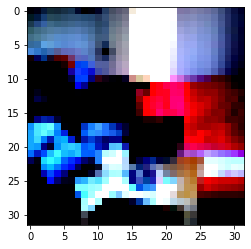

In [20]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
imshow(train_set[1][0])

## test device

In [21]:
# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


## Define Conv Net

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0,
        #        dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        
        # Linear(in_features, out_features, bias=True)
        self.fc1 = nn.Linear(500, 50)
        self.fc2 = nn.Linear(50, 18)
        
        # MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        self.max_pool = nn.MaxPool2d(2)
        # ReLU(inplace=False)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        #print(x.shape)
        x = self.relu(self.max_pool(self.conv2_drop(self.conv2(x))))
        #print(x.shape)
        x = x.view(-1, 500)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x, torch.sigmoid(x)


## Define LSTM net

In [23]:
class Netrnn(nn.Module):
    def __init__(self):
        super(Netrnn, self).__init__()
        self.lstm = nn.LSTM(25, 32, batch_first =True,bidirectional=True, dropout=0.2)
        self.linear = nn.Linear(32*2,18)

    def forward(self, sentence):
        
        lstm_out, (h_n,c_n) = self.lstm(sentence)
        hidden_out =torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        output = self.linear(hidden_out)
        sig_output = torch.sigmoid(output)
        
        return output, sig_output

## Combine two nets

In [30]:
class Combine(nn.Module):
    def __init__(self):
        super(Combine, self).__init__()
        self.cnn = Net()
        self.rnn = Netrnn()
        

    def forward(self, x, embeddings):
        output1, sig_output1 = self.cnn(x)
        output2, sig_output2 = self.rnn(embeddings)
        output = output1 + output2
        sig_output = torch.sigmoid(output)
        return output, sig_output
    
model = Combine().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)

## Train the network

In [31]:
trainset_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=0)
valset_loader = DataLoader(val_set, batch_size=1000, shuffle=False, num_workers=0)

In [32]:
len(valset_loader.dataset)

6000

In [33]:
from time import time
def train(epoch, log_interval=100):
      # set training mode
    iteration = 0
    for ep in range(epoch):
        model.train()
        start = time()
        for batch_idx, (data, target, embeddings) in enumerate(trainset_loader):
            # bring data to the computing device, e.g. GPU
            data, target, embeddings = data.to(device), target.to(device), embeddings.float().to(device)

            # forward pass
            output, sig_x = model(x=data, embeddings=embeddings)
            criterion = nn.BCEWithLogitsLoss()
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
          
            if iteration % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    ep, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
                
            iteration += 1
            
        model.eval()
        outputs, sig_output = model(x=data, embeddings=embeddings)        
        pred_result_list = test()
        end = time()
        print('{:.2f}s'.format(end-start))
    return pred_result_list

## Test the val dataset

In [34]:
def test():
    model.eval()  # set evaluation mode
    f1_list = []
    pred_result_list = []
    with torch.no_grad():
        for data, target, embeddings in valset_loader:
            data = data.to(device)
            embeddings = embeddings.float().to(device)
            output, sig_x = model(data, embeddings)
            f1_list.append(fbeta_score(target.numpy(), sig_x.cpu().detach().numpy()>0.5,beta=1, average='samples'))
    f1_avg = sum(f1_list) / 6
    print('Overall F1-Score(samples): ', f1_avg)
    return pred_result_list

In [35]:
pred_result_list = train(15)

Train Epoch: 0 [0/24000 (0%)]	Loss: 0.700548
Train Epoch: 0 [6400/24000 (27%)]	Loss: 0.203774
Train Epoch: 0 [12800/24000 (53%)]	Loss: 0.159026
Train Epoch: 0 [19200/24000 (80%)]	Loss: 0.157462
Overall F1-Score(samples):  0.6520661375661375
16.46s
Train Epoch: 1 [1600/24000 (7%)]	Loss: 0.134067
Train Epoch: 1 [8000/24000 (33%)]	Loss: 0.134083
Train Epoch: 1 [14400/24000 (60%)]	Loss: 0.127975
Train Epoch: 1 [20800/24000 (87%)]	Loss: 0.135514
Overall F1-Score(samples):  0.7521550264550264
16.16s
Train Epoch: 2 [3200/24000 (13%)]	Loss: 0.127032
Train Epoch: 2 [9600/24000 (40%)]	Loss: 0.114340
Train Epoch: 2 [16000/24000 (67%)]	Loss: 0.137872
Train Epoch: 2 [22400/24000 (93%)]	Loss: 0.117480
Overall F1-Score(samples):  0.7813685185185185
16.51s
Train Epoch: 3 [4800/24000 (20%)]	Loss: 0.110075
Train Epoch: 3 [11200/24000 (47%)]	Loss: 0.079895
Train Epoch: 3 [17600/24000 (73%)]	Loss: 0.109027
Overall F1-Score(samples):  0.8100849206349207
16.47s
Train Epoch: 4 [0/24000 (0%)]	Loss: 0.117738
T